# Jupyter Notebook: SLAM Lidar for the detection of PM1, PM2.5 and PM10 in Underground Mining Environments

## This notebook explores the relationship between Velodyne data captured by a Hovermap 100 SLAM Lidar scanner and a Trolex Air XD Particulate Matter Monitor.

Ideally, we should be able to determine the correlation between these two datasources to assess whether there exists a meaningful way to infer particulate matter mass concentrations using Lidar.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

Import Trolex Dataset

In [2]:
trolex_dataset = pd.read_csv("_data/IE01117_2024_10_4_002.trx", header=23)
trolex_dataset.head()

,HH,MM,SS,0.41,0.56,0.83,1.15,1.50,2.00,2.65,...,PMC_AVG_1,PMC_AVG_2,PMD Value,PMD_AVG_1,PMD_AVG_2,TSP_Value,TSP_AVG_1,TSP_AVG_2,Laser Curr,Status
0,8,30,11,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1
1,8,30,21,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1
2,8,30,31,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1
3,8,30,41,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1
4,8,30,51,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1


Create a Timestamp object for each row

In [3]:
def create_datetime(row):
    datetime_row = datetime(2024, 10, 4, int(row['HH']), int(row['MM']), int(row["SS"]))
    return datetime_row
trolex_dataset['Timestamp'] = trolex_dataset.apply(lambda row: create_datetime(row), axis=1)
trolex_dataset.head()

,HH,MM,SS,0.41,0.56,0.83,1.15,1.50,2.00,2.65,...,PMC_AVG_2,PMD Value,PMD_AVG_1,PMD_AVG_2,TSP_Value,TSP_AVG_1,TSP_AVG_2,Laser Curr,Status,Timestamp
0,8,30,11,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:11
1,8,30,21,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:21
2,8,30,31,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:31
3,8,30,41,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:41
4,8,30,51,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:51


Narrow to instances where the cap is "open". This gives 423 observations, logging every 10 seconds. In total, there are 70.5 minutes (1.175 hours) of data collected.

In [4]:
trolex_dataset_open = trolex_dataset[trolex_dataset[' Status'] == 0]

Exploratory data plots:

Text(0.5, 1.0, 'PM LOADING ug/m3')

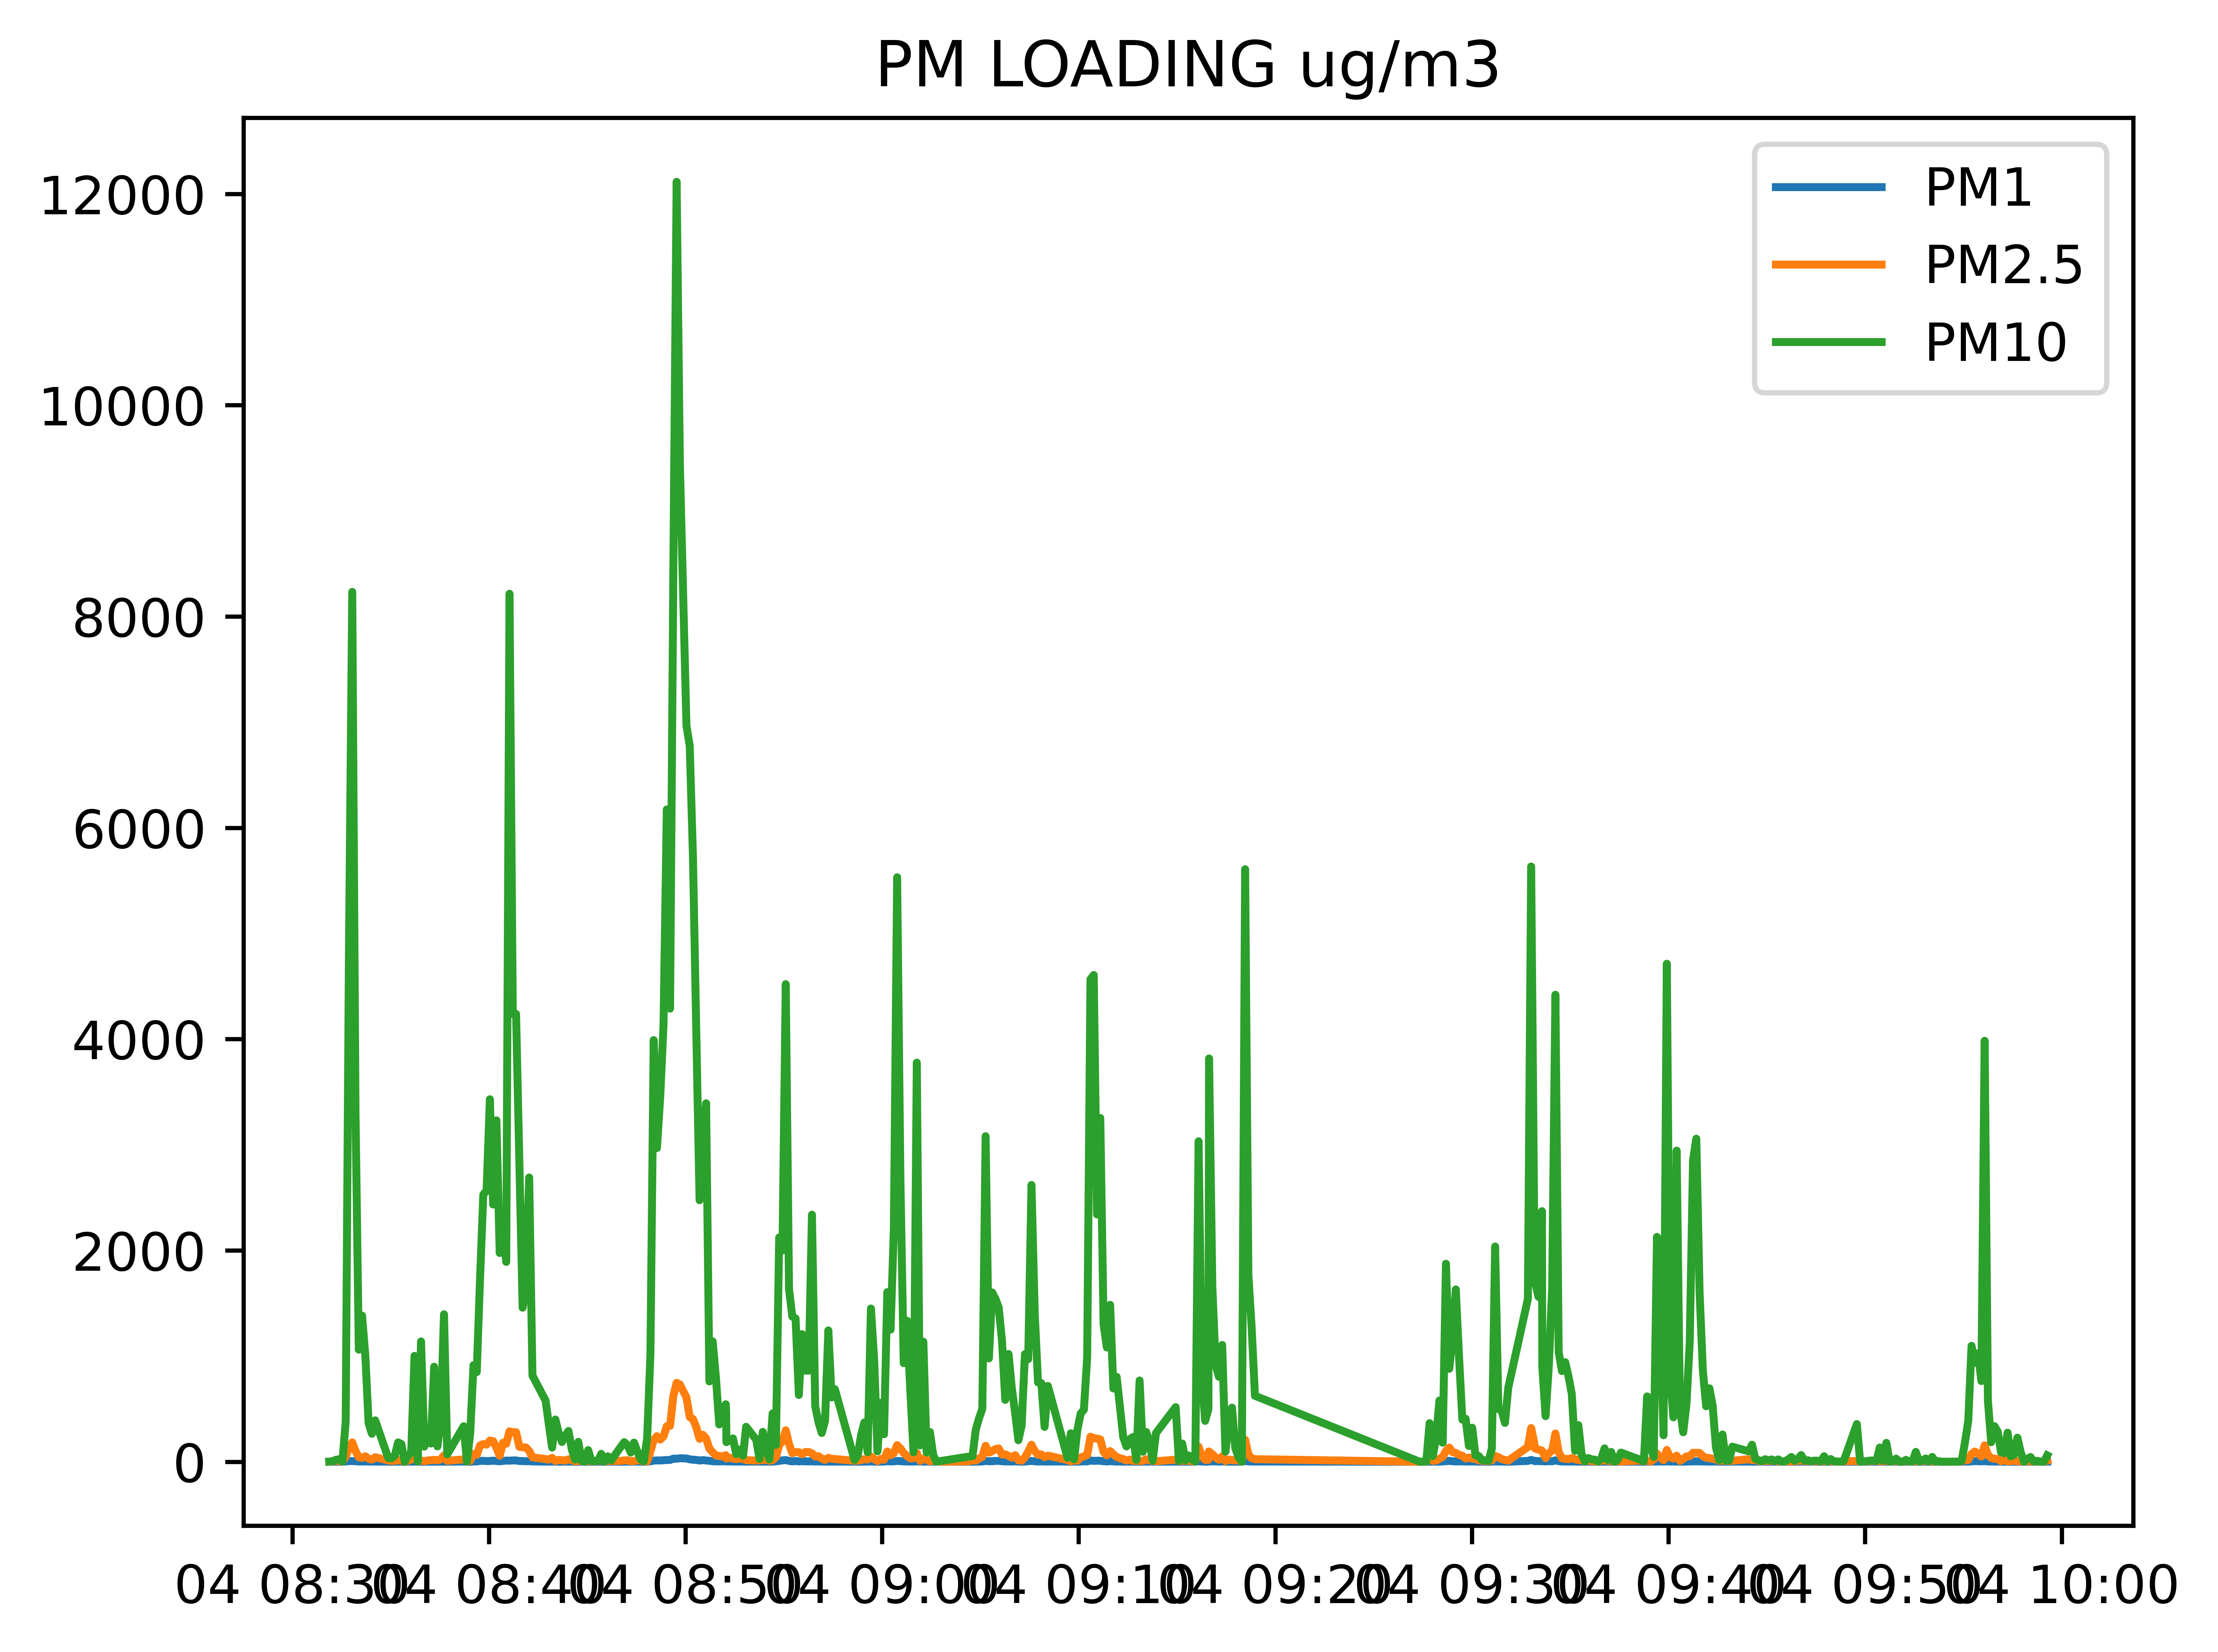

In [5]:
fig = plt.figure(dpi=1200)
plt.plot(trolex_dataset_open['Timestamp'], trolex_dataset_open['PMA Value'], label='PM1')
plt.plot(trolex_dataset_open['Timestamp'], trolex_dataset_open['PMB Value'], label='PM2.5')
plt.plot(trolex_dataset_open['Timestamp'], trolex_dataset_open['PMD Value'], label='PM10')
plt.legend()
plt.title('PM LOADING ug/m3')

High correlation between PM1 (PMA), PM2.5 (PMB) and PM10 (PMD) is to be expected

In [6]:
trolex_dataset_open[['PMA Value', 'PMB Value', 'PMD Value']].corr()

,PMA Value,PMB Value,PMD Value
PMA Value,1.000000,0.979813,0.866670
PMB Value,0.979813,1.000000,0.915523
PMD Value,0.866670,0.915523,1.000000


## Import Hovermap Data using Bagpy

In [7]:
import struct

# key parameters

x_off = 0
y_off = 4
z_off = 7
time_off = 16
intensity_off = 24
ring_off = 28
returnNum_off = 29
point_step = 32

def extract_point_data(data):
    point_data = {}

    point_data['x'] = struct.unpack('f', data[x_off:x_off + 4])[0]
    point_data['y'] = struct.unpack('f', data[y_off:y_off + 4])[0]
    point_data['z'] = struct.unpack('f', data[z_off:z_off + 4])[0]
    point_data['timestep'] = struct.unpack('d', data[time_off:time_off + 8])[0]
    point_data['intensity'] = struct.unpack('f', data[intensity_off:intensity_off+4])[0]
    point_data['ring'] = struct.unpack('B', data[ring_off:ring_off+1])[0]
    point_data['returnNum'] = struct.unpack('B', data[returnNum_off:returnNum_off+1])[0]

    return point_data

def extract_all_points(data, numPoints):
    all_points = []
    for i in range(numPoints):
        start_index = i * point_step
        point_data = extract_point_data(data[start_index:start_index+point_step])
        all_points.append(point_data)
    return all_points


def extract_velodyne_data_to_csv(velodyne_data):
    df_out = pd.DataFrame(columns=['Time', '1m', '1m_intensity', '1m_return', '10cm', '10cm_intensity', '10cm_return', '1cm', '1cm_intensity', '1cm_return', '1mm', '1mm_intensity', '1mm_return', "100um", '100um_intensity', '100um_return'])
    for i in range(len(velodyne_data)):
        relevant_data = []
        relevant_data.append(datetime.fromtimestamp(velodyne_data.loc[i, 'Time']))
        cloud_data = velodyne_data.loc[i, "data"]
        cloud_bytes = cloud_data.encode('latin1')
        num_points = len(cloud_bytes) // point_step
        all_points = extract_all_points(cloud_bytes, num_points)

        df_all_points = pd.DataFrame(all_points)

        df_all_points['distance'] = df_all_points.apply(lambda row: np.sqrt((row.x ** 2) + (row.y ** 2) + (row.z ** 2)),
                                                        axis=1)

        for j in range(5):
            subset = df_all_points.loc[df_all_points['distance'] <= (10 ** (-1 * j))]
            loading = len(subset)
            relevant_data.append(loading)
            intensity = subset['intensity'].mean()
            relevant_data.append(intensity)
            returnNum = subset['returnNum'].mean()
            relevant_data.append(returnNum)
            #relevant_data.append([loading, intensity, returnNum])
        df_out.loc[len(df_out)] = relevant_data
    return df_out


In [8]:
import glob
from bagpy import bagreader

hovermap_files = glob.glob('_data/*.bag')
count = 1
for filename in hovermap_files:
        b = bagreader(filename)
        data = b.message_by_topic('/velodyne_points')
        df_data = pd.read_csv(data)
        df_out = extract_velodyne_data_to_csv(df_data)
        df_out.to_csv("_data/hovermap{}.csv".format(count))
        count += 1
if not hovermap_files:
    print('empty')


[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-31-36_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-34-35_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-38-21_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-42-36_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-46-27_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-49-46_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-53-21_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-15-58-20_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-16-04-07_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-16-09-06_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrolex1_2024-10-04-16-14-36_0 already exists. Not creating.
[INFO]  Data folder _data\SXtrol

In [9]:
import glob
from bagpy import bagreader

hovermap_unpacked_files = glob.glob('_data/SXtrolex1*/SXtrolex1*/velodyne_points.csv')
count = 1
for filename in hovermap_unpacked_files:
    print(count)
    df_data = pd.read_csv(filename)
    df_out = extract_velodyne_data_to_csv(df_data)
    df_out.to_csv("_data/hovermap{}.csv".format(count))
    count += 1

Re-import hovermap data as csv files and combine

In [10]:
import glob
hovermap_csvs = glob.glob('_data/hovermap*.csv')

dfs = []
for filename in hovermap_csvs:
    data = pd.read_csv(filename)
    data = data.drop(data.columns[0], axis=1)
    dfs.append(data)
hovermap_data = pd.concat(dfs)

Calculate the rolling difference for the various distances. Hopefully, if the counts alone do not suffice, we can figure out some measure of rate that particles are staying on the read head.

In [11]:
hovermap_data.sort_values(by='Time', inplace=True)

hovermap_data['1m_diff'] = hovermap_data['1m'].diff()
hovermap_data['10cm_diff'] = hovermap_data['10cm'].diff()
hovermap_data['1cm_diff'] = hovermap_data['1cm'].diff()
hovermap_data['1mm_diff'] = hovermap_data['1mm'].diff()
hovermap_data['100um_diff'] = hovermap_data['100um'].diff()

In [12]:
hovermap_data[['1m', '10cm', '1cm', '1mm', '100um', '1m_diff', '10cm_diff', '1cm_diff', '1mm_diff', '100um_diff']].corr()

,1m,10cm,1cm,1mm,100um,1m_diff,10cm_diff,1cm_diff,1mm_diff,100um_diff
1m,1.000000,0.996621,0.995559,0.995005,0.909617,0.316441,0.319178,0.316551,0.314770,0.262696
10cm,0.996621,1.000000,0.999343,0.998900,0.902596,0.320791,0.329045,0.326707,0.325055,0.266534
1cm,0.995559,0.999343,1.000000,0.999692,0.902299,0.322911,0.331668,0.330903,0.329424,0.269547
1mm,0.995005,0.998900,0.999692,1.000000,0.902479,0.323890,0.332835,0.332299,0.331480,0.271099
100um,0.909617,0.902596,0.902299,0.902479,1.000000,0.256223,0.263992,0.264122,0.263945,0.304957
1m_diff,0.316441,0.320791,0.322911,0.323890,0.256223,1.000000,0.991782,0.988099,0.985911,0.835177
10cm_diff,0.319178,0.329045,0.331668,0.332835,0.263992,0.991782,1.000000,0.997604,0.995980,0.837848
1cm_diff,0.316551,0.326707,0.330903,0.332299,0.264122,0.988099,0.997604,1.000000,0.999000,0.840341
1mm_diff,0.314770,0.325055,0.329424,0.331480,0.263945,0.985911,0.995980,0.999000,1.000000,0.841683
100um_diff,0.262696,0.266534,0.269547,0.271099,0.304957,0.835177,0.837848,0.840341,0.841683,1.000000


In [13]:
hovermap_data

,Time,1m,1m_intensity,1m_return,10cm,10cm_intensity,10cm_return,1cm,1cm_intensity,1cm_return,...,1mm_intensity,1mm_return,100um,100um_intensity,100um_return,1m_diff,10cm_diff,1cm_diff,1mm_diff,100um_diff
0,2024-10-04 08:31:36.876321,936,8.097507e+33,86.902778,892,8.356717e+33,86.628924,883,8.340722e+33,86.870895,...,8.350178e+33,86.833333,720,9.509201e+33,87.005556,NaN,NaN,NaN,NaN,NaN
1,2024-10-04 08:31:36.927147,883,2.060923e+34,87.015855,838,2.152396e+34,86.743437,832,2.167918e+34,86.691106,...,2.187769e+34,86.782238,679,2.590620e+34,87.136966,-53.0,-54.0,-51.0,-60.0,-41.0
2,2024-10-04 08:31:36.977388,905,5.123943e+34,87.634254,865,3.651784e+34,87.368786,855,3.688224e+34,87.447953,...,3.692543e+34,87.494145,699,3.911144e+34,88.111588,22.0,27.0,23.0,32.0,20.0
3,2024-10-04 08:31:37.027810,801,1.070830e+35,88.575531,757,1.082607e+35,88.524439,752,1.077402e+35,88.488032,...,1.082686e+35,88.621658,661,1.218159e+35,89.228442,-104.0,-108.0,-103.0,-106.0,-38.0
4,2024-10-04 08:31:37.078054,891,8.400216e+34,87.032548,849,8.794725e+34,86.805654,843,8.850963e+34,86.858837,...,8.861474e+34,86.852732,705,1.051505e+35,87.253901,90.0,92.0,91.0,94.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5066,2024-10-04 09:58:44.884207,1016,3.730658e+33,86.287402,967,3.790275e+33,86.465357,957,3.792475e+33,86.390805,...,3.808393e+33,86.279119,753,4.321387e+33,87.597610,3.0,12.0,12.0,9.0,-24.0
5067,2024-10-04 09:58:44.934775,930,2.513759e+34,82.762366,878,2.632105e+34,83.120729,867,2.665500e+34,83.070358,...,2.674755e+34,83.108796,673,3.388712e+34,85.561664,-86.0,-89.0,-90.0,-89.0,-80.0
5068,2024-10-04 09:58:44.984946,927,4.317769e+33,85.321467,868,4.425858e+33,84.866359,855,4.451353e+33,84.854971,...,4.472276e+33,84.823737,705,4.916787e+33,86.106383,-3.0,-10.0,-12.0,-13.0,32.0
5069,2024-10-04 09:58:45.035405,867,9.763615e+34,86.403691,826,1.023743e+35,85.989104,819,1.032057e+35,86.087912,...,1.039454e+35,86.082411,709,1.176306e+35,86.287729,-60.0,-42.0,-36.0,-38.0,4.0


In [14]:
#subsamp_data = hovermap_data.sample(frac=0.1)
#plt.scatter(subsamp_data['Time'], subsamp_data['10cm'])
hovermap_data['Timestamp'] = pd.to_datetime(hovermap_data['Time'])

In [15]:
trolex_dataset_open

,HH,MM,SS,0.41,0.56,0.83,1.15,1.50,2.00,2.65,...,PMC_AVG_2,PMD Value,PMD_AVG_1,PMD_AVG_2,TSP_Value,TSP_AVG_1,TSP_AVG_2,Laser Curr,Status,Timestamp
12,8,31,53,9,3,0,1,0,0,0,...,0.00,1.49,0.00,0.00,1.49,0.00,0.00,65535,0,2024-10-04 08:31:53
13,8,32,3,7,1,2,0,0,1,0,...,0.00,4.90,0.00,0.00,4.90,0.00,0.00,65535,0,2024-10-04 08:32:03
14,8,32,13,10,0,0,1,0,2,1,...,0.01,18.57,1.09,0.03,18.58,1.71,0.05,65535,0,2024-10-04 08:32:13
15,8,32,23,5,0,1,0,1,0,0,...,0.01,23.83,1.09,0.03,23.94,1.71,0.05,65535,0,2024-10-04 08:32:23
16,8,32,33,5,1,2,1,0,0,0,...,0.01,1.51,1.09,0.03,1.51,1.71,0.05,65535,0,2024-10-04 08:32:33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541,9,58,35,9,3,1,0,0,0,0,...,29.07,0.79,134.14,127.70,0.79,361.98,354.73,65535,0,2024-10-04 09:58:35
542,9,58,46,10,0,1,0,0,0,1,...,29.07,9.24,134.14,127.70,9.25,361.98,354.73,65535,0,2024-10-04 09:58:46
543,9,58,55,15,2,0,0,0,0,0,...,29.07,0.62,134.14,127.70,0.62,361.98,354.73,65535,0,2024-10-04 09:58:55
544,9,59,6,15,2,0,0,0,0,0,...,29.07,0.62,134.14,127.70,0.62,361.98,354.73,65535,0,2024-10-04 09:59:06


We need to make the sampling rates match up here. So, we can try to align.

In [16]:
trolex_dataset['Timestamp']

0     2024-10-04 08:30:11
1     2024-10-04 08:30:21
2     2024-10-04 08:30:31
3     2024-10-04 08:30:41
4     2024-10-04 08:30:51
              ...        
554   2024-10-04 10:00:46
555   2024-10-04 10:00:56
556   2024-10-04 10:01:06
557   2024-10-04 10:01:16
558   2024-10-04 10:01:26
Name: Timestamp, Length: 559, dtype: datetime64[ns]

In [17]:
trolex_dataset.sort_values(by='Timestamp', inplace=True)
trolex_dataset['Timestamp'] = pd.to_datetime(trolex_dataset['Timestamp']).dt.tz_localize(None)
hovermap_data['Timestamp'] = pd.to_datetime(hovermap_data['Timestamp']).dt.tz_localize(None)
hovermap_data['Timestamp'] = hovermap_data['Timestamp'].dt.round('s')
hovermap_data.sort_values(by="Timestamp", inplace=True)
trolex_dataset['prev_time'] = trolex_dataset['Timestamp'].shift(1)
summary_stats = []

for index, row in trolex_dataset.iterrows():
    if pd.isnull(row['prev_time']):
        continue
    hovermap_interval = hovermap_data[(hovermap_data['Timestamp'] > row['prev_time']) & (hovermap_data['Timestamp'] <= row['Timestamp'])]
    print(len(hovermap_interval))
    summary = {
        'Time' : row['Timestamp'],
        'Prev' : row['prev_time'],
        'Status' : row[' Status'],
        'PM1' : row['PMA Value'],
        'PM2.5' : row['PMB Value'],
        'PM4.25' : row['PMC Value'],
        'PM10' : row['PMD Value'],
        '1m_intmean' : hovermap_interval['1m_intensity'].mean(),
        '10cm_intmean' : hovermap_interval['10cm_intensity'].mean(),
        '1cm_intmean' : hovermap_interval['1cm_intensity'].mean(),
        '1mm_intmean' : hovermap_interval['1mm_intensity'].mean(),
        '100um_intmean' : hovermap_interval['100um_intensity'].mean(),
        '1m_intrange' : hovermap_interval['1m_intensity'].max() - hovermap_interval['1m_intensity'].min(),
        '10cm_intrange' : hovermap_interval['10cm_intensity'].max() - hovermap_interval['10cm_intensity'].min(),
        '1cm_intrange' : hovermap_interval['1cm_intensity'].max() - hovermap_interval['1cm_intensity'].min(),
        '1mm_intrange' : hovermap_interval['1mm_intensity'].max() - hovermap_interval['1mm_intensity'].min(),
        '100um_intrange' : hovermap_interval['100um_intensity'].max() - hovermap_interval['100um_intensity'].min(),
        '1m_returnmean' : hovermap_interval['1m_return'].mean(),
        '10cm_returnmean' : hovermap_interval['10cm_return'].mean(),
        '1cm_returnmean' : hovermap_interval['1cm_return'].mean(),
        '1mm_returnmean' : hovermap_interval['1mm_return'].mean(),
        '100um_returnmean' : hovermap_interval['100um_return'].mean(),
        '1m_retrange' : hovermap_interval['1m_return'].max() - hovermap_interval['1m_return'].min(),
        '10cm_retrange' : hovermap_interval['10cm_return'].max() - hovermap_interval['10cm_return'].min(),
        '1cm_retrange' : hovermap_interval['1cm_return'].max() - hovermap_interval['1cm_return'].min(),
        '1mm_retrange' : hovermap_interval['1mm_return'].max() - hovermap_interval['1mm_return'].min(),
        '100um_retrange' : hovermap_interval['100um_return'].max() - hovermap_interval['100um_return'].min(),
        '1m_mean' : hovermap_interval['1m'].mean(),
        '10cm_mean' : hovermap_interval['10cm'].mean(),
        '1cm_mean' : hovermap_interval['1cm'].mean(),
        '1mm_mean' : hovermap_interval['1mm'].mean(),
        '100um_mean' : hovermap_interval['100um'].mean(),
        '1m_median' : hovermap_interval['1m'].median(),
        '10cm_median' : hovermap_interval['10cm'].median(),
        '1cm_median' : hovermap_interval['1cm'].median(),
        '1mm_median' : hovermap_interval['1mm'].median(),
        '100um_median' : hovermap_interval['100um'].median(),
        '1m_std' : hovermap_interval['1m'].std(),
        '10cm_std' : hovermap_interval['10cm'].std(),
        '1cm_std' : hovermap_interval['1cm'].std(),
        '1mm_std' : hovermap_interval['1mm'].std(),
        '100um_std' : hovermap_interval['100um'].std(),
        '1m_sum' : hovermap_interval['1m'].sum(),
        '10cm_sum' : hovermap_interval['10cm'].sum(),
        '1cm_sum' : hovermap_interval['1cm'].sum(),
        '1mm_sum' : hovermap_interval['1mm'].sum(),
        '100um_sum' : hovermap_interval['100um'].sum(),
        '1m_range' : hovermap_interval['1m'].max() - hovermap_interval['1m'].min(),
        '10cm_range' : hovermap_interval['10cm'].max() - hovermap_interval['10cm'].min(),
        '1cm_range' : hovermap_interval['1cm'].max() - hovermap_interval['1cm'].min(),
        '1mm_range' : hovermap_interval['1mm'].max() - hovermap_interval['1mm'].min(),
        '100um_range' : hovermap_interval['100um'].max() - hovermap_interval['100um'].min(),
        '1m_diffmean' : hovermap_interval['1m_diff'].mean(),
        '10cm_diffmean' : hovermap_interval['10cm_diff'].mean(),
        '1cm_diffmean' : hovermap_interval['1cm_diff'].mean(),
        '1mm_diffmean' : hovermap_interval['1mm_diff'].mean(),
        '100um_diffmean' : hovermap_interval['100um_diff'].mean(),
        '1m_diffmedian' : hovermap_interval['1m_diff'].median(),
        '10cm_diffmedian' : hovermap_interval['10cm_diff'].median(),
        '1cm_diffmedian' : hovermap_interval['1cm_diff'].median(),
        '1mm_diffmedian' : hovermap_interval['1mm_diff'].median(),
        '100um_diffmedian' : hovermap_interval['100um_diff'].median(),
        '1m_diffstd' : hovermap_interval['1m_diff'].std(),
        '10cm_diffstd' : hovermap_interval['10cm_diff'].std(),
        '1cm_diffstd' : hovermap_interval['1cm_diff'].std(),
        '1mm_diffstd' : hovermap_interval['1mm_diff'].std(),
        '100um_diffstd' : hovermap_interval['100um_diff'].std(),
        '1m_diffsum' : hovermap_interval['1m_diff'].sum(),
        '10cm_diffsum' : hovermap_interval['10cm_diff'].sum(),
        '1cm_diffsum' : hovermap_interval['1cm_diff'].sum(),
        '1mm_diffsum' : hovermap_interval['1mm_diff'].sum(),
        '100um_diffsum' : hovermap_interval['100um_diff'].sum(),
        '1m_diffrange' : hovermap_interval['1m_diff'].max() - hovermap_interval['1m_diff'].min(),
        '10cm_diffrange' : hovermap_interval['10cm_diff'].max() - hovermap_interval['10cm_diff'].min(),
        '1cm_diffrange' : hovermap_interval['1cm_diff'].max() - hovermap_interval['1cm_diff'].min(),
        '1mm_diffrange' : hovermap_interval['1mm_diff'].max() - hovermap_interval['1mm_diff'].min(),
        '100um_diffrange' : hovermap_interval['100um_diff'].max() - hovermap_interval['100um_diff'].min()
    }
    summary_stats.append(summary)

summary_df = pd.DataFrame(summary_stats)

0
0
0
0
0
0
0
0
0
0
132
198
198
199
198
198
199
198
198
198
199
198
198
199
13
0
0
0
150
198
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
72
0
0
0
0
31
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
199
198
198
198
199
80
0
0
0
129
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
199
198
3
0
0
110
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
111
0
0
129
199
198
198
199
198
198
198
199
198
198
199
198
198
20
20
198
198
199
198
110
0
0
91
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
199
198
3
0
0
0
0
0
109
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
198
162
0
0
0
0
0
0
0
0
0
169
198
198
199
198
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
55
0
0
0
0
0
191
198
199
198
198
198
199
198
198
199
198
198
199
198
198
198
199
198
198
199
198
198
198
199
198
198
199
106
0
0
0
0
0
190
198
198
199
198
198
198
199


In [18]:
summary_df

,Time,Prev,Status,PM1,PM2.5,PM4.25,PM10,1m_intmean,10cm_intmean,1cm_intmean,...,1m_diffsum,10cm_diffsum,1cm_diffsum,1mm_diffsum,100um_diffsum,1m_diffrange,10cm_diffrange,1cm_diffrange,1mm_diffrange,100um_diffrange
0,2024-10-04 08:30:21,2024-10-04 08:30:11,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2024-10-04 08:30:31,2024-10-04 08:30:21,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2024-10-04 08:30:41,2024-10-04 08:30:31,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,2024-10-04 08:30:51,2024-10-04 08:30:41,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,2024-10-04 08:31:01,2024-10-04 08:30:51,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
553,2024-10-04 10:00:46,2024-10-04 10:00:36,1,0.03,0.03,0.03,0.03,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
554,2024-10-04 10:00:56,2024-10-04 10:00:46,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
555,2024-10-04 10:01:06,2024-10-04 10:00:56,1,0.03,0.03,0.03,0.03,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
556,2024-10-04 10:01:16,2024-10-04 10:01:06,1,0.00,0.00,0.00,0.00,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [19]:
summary_df_no_NaN = summary_df.dropna(how='any')
combined_data = summary_df_no_NaN[summary_df_no_NaN['Status'] == 0]
combined_data.columns

Index(['Time', 'Prev', 'Status', 'PM1', 'PM2.5', 'PM4.25', 'PM10',
       '1m_intmean', '10cm_intmean', '1cm_intmean', '1mm_intmean',
       '100um_intmean', '1m_intrange', '10cm_intrange', '1cm_intrange',
       '1mm_intrange', '100um_intrange', '1m_returnmean', '10cm_returnmean',
       '1cm_returnmean', '1mm_returnmean', '100um_returnmean', '1m_retrange',
       '10cm_retrange', '1cm_retrange', '1mm_retrange', '100um_retrange',
       '1m_mean', '10cm_mean', '1cm_mean', '1mm_mean', '100um_mean',
       '1m_median', '10cm_median', '1cm_median', '1mm_median', '100um_median',
       '1m_std', '10cm_std', '1cm_std', '1mm_std', '100um_std', '1m_sum',
       '10cm_sum', '1cm_sum', '1mm_sum', '100um_sum', '1m_range', '10cm_range',
       '1cm_range', '1mm_range', '100um_range', '1m_diffmean', '10cm_diffmean',
       '1cm_diffmean', '1mm_diffmean', '100um_diffmean', '1m_diffmedian',
       '10cm_diffmedian', '1cm_diffmedian', '1mm_diffmedian',
       '100um_diffmedian', '1m_diffstd', '10cm_

In [20]:
trolex_dataset.set_index('Timestamp', inplace=True)
hovermap_data.set_index('Timestamp', inplace=True)


In [21]:
resampled_trolex = trolex_dataset.reindex(hovermap_data.index, method='nearest')

In [22]:
merged_data = pd.concat([resampled_trolex, hovermap_data], axis=1, join='inner')  # Ensures matching rows
merged_data

,HH,MM,SS,0.41,0.56,0.83,1.15,1.50,2.00,2.65,...,1mm_intensity,1mm_return,100um,100um_intensity,100um_return,1m_diff,10cm_diff,1cm_diff,1mm_diff,100um_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,8.350178e+33,86.833333,720,9.509201e+33,87.005556,NaN,NaN,NaN,NaN,NaN
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,4.256532e+33,86.745392,754,4.307579e+33,86.992042,44.0,38.0,38.0,39.0,31.0
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,4.402778e+33,88.188179,723,4.479832e+33,88.881051,46.0,34.0,35.0,36.0,27.0
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,2.750788e+34,87.637717,676,3.163971e+34,87.239645,-5.0,-11.0,-11.0,-9.0,-28.0
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,4.451599e+33,86.402454,704,4.620525e+33,86.801136,25.0,20.0,24.0,21.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-04 09:58:45,9,58,46,10,0,1,0,0,0,1,...,4.356172e+33,82.852107,896,4.110595e+33,87.483259,-31.0,-34.0,-33.0,-33.0,-36.0
2024-10-04 09:58:45,9,58,46,10,0,1,0,0,0,1,...,1.665113e+35,86.191489,807,1.931123e+35,86.044610,-286.0,-277.0,-253.0,-242.0,-41.0
2024-10-04 09:58:45,9,58,46,10,0,1,0,0,0,1,...,1.039454e+35,86.082411,709,1.176306e+35,86.287729,-60.0,-42.0,-36.0,-38.0,4.0


In [23]:
merged_data_no_NaN = merged_data.dropna(how='any')
merged_data_no_NaN.head()
#combined_data = merged_data_no_NaN[merged_data_no_NaN[' Status'] == 0]
#combined_data.columns

,HH,MM,SS,0.41,0.56,0.83,1.15,1.50,2.00,2.65,...,1mm_intensity,1mm_return,100um,100um_intensity,100um_return,1m_diff,10cm_diff,1cm_diff,1mm_diff,100um_diff
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,4.256532e+33,86.745392,754,4.307579e+33,86.992042,44.0,38.0,38.0,39.0,31.0
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,4.402778e+33,88.188179,723,4.479832e+33,88.881051,46.0,34.0,35.0,36.0,27.0
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,2.750788e+34,87.637717,676,3.163971e+34,87.239645,-5.0,-11.0,-11.0,-9.0,-28.0
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,4.451599e+33,86.402454,704,4.620525e+33,86.801136,25.0,20.0,24.0,21.0,10.0
2024-10-04 08:31:37,8,31,33,0,0,0,0,0,0,0,...,8.075521e+34,89.646096,694,9.195364e+34,89.589337,-49.0,-38.0,-38.0,-39.0,-18.0


In [24]:
c=1
for group_value, group_df in merged_data.groupby(merged_data.index):
    group_df.to_csv("_data/Training Images/{}.csv".format(c))
    c+= 1

In [25]:
combined_data.corr(method="spearman", numeric_only=True).to_csv('_data/corr.csv')

In [26]:
#combined_data.corr().to_csv('_data/corr.csv')


In [27]:
trolex_dataset.head()

,HH,MM,SS,0.41,0.56,0.83,1.15,1.50,2.00,2.65,...,PMC_AVG_2,PMD Value,PMD_AVG_1,PMD_AVG_2,TSP_Value,TSP_AVG_1,TSP_AVG_2,Laser Curr,Status,prev_time
Timestamp,,,,,,,,,,,,,,,,,,,,,
2024-10-04 08:30:11,8,30,11,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,NaT
2024-10-04 08:30:21,8,30,21,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:11
2024-10-04 08:30:31,8,30,31,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:21
2024-10-04 08:30:41,8,30,41,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:31
2024-10-04 08:30:51,8,30,51,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,65535,1,2024-10-04 08:30:41


The correlation is really, really, bad. We can now try linear regression modeling.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [29]:
X = combined_data.drop(['Time', 'Prev', 'Status', 'PM1', 'PM2.5', "PM4.25", "PM10"], axis=1)#combined_data[['1m_mean', '10cm_mean', '1cm_mean', '1mm_mean']]
y = combined_data[["PM10"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

R2 score is really bad, too.

In [30]:
r2_score(y_test, y_pred)
#mean_squared_error(y_test, y_pred)

-0.10146686375640845

Try Random forest now

In [31]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

C:\Users\isaac\anaconda3\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [32]:
r2_score(y_test, y_pred_rf)

-0.08503412176130021

In [33]:
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense

# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network model
nn_model = Sequential()
nn_model.add(Dense(64, activation='relu'))#, input_shape=(X_train_scaled.shape[1],)))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(y.shape[1]))  # Output layer for multiple targets

# Compile the model
nn_model.compile(optimizer='adam', loss='mse')

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=0)

# Predictions
y_pred_nn = nn_model.predict(X_test_scaled)

# Evaluation
print("Mean Squared Error (NN):", mean_squared_error(y_test, y_pred_nn))
print("R² Score (NN):", r2_score(y_test, y_pred_nn))


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Mean Squared Error (NN): 2617252.1741757994
R² Score (NN): -0.1143040657043457


In [34]:
y.shape

(400, 1)

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import LSTM, Dense
from keras import Input



# Features and target variables
X = combined_data[['1m_mean', '10cm_mean', '1cm_mean', '1mm_mean']].values
y = combined_data[['PM1', 'PM2.5', 'PM4.25', 'PM10']].values

# Normalize the features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Reshape X to 3D for LSTM (samples, timesteps, features)
# For simplicity, let's use 1 timestep, meaning no look-back
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Build LSTM model

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

x = LSTM(64, activation='relu')(input_layer)
x = Dense(32, activation='relu')(x)
output_layer = Dense(y_train.shape[1])(x)

model = Model(inputs=input_layer, outputs=output_layer)
'''
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1]))  # Output layer with the same number of neurons as target variables (PM1, PM2.5, etc.)
'''
# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

# Predictions
y_pred = model.predict(X_test)

# Rescale the predictions back to original scale
y_pred_rescaled = scaler_y.inverse_transform(y_pred)

# Evaluation (you can use any metric suitable for your task)
from sklearn.metrics import mean_squared_error, r2_score
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0513
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9202 
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9941 
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9468 
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9032 
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0692 
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7309 
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7196 
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7621 
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2049 
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9583 
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7684 
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8120 
Epoch 14/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8782 
Epoch 15/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0599 
Epoch

In [36]:
combined_data

,Time,Prev,Status,PM1,PM2.5,PM4.25,PM10,1m_intmean,10cm_intmean,1cm_intmean,...,1m_diffsum,10cm_diffsum,1cm_diffsum,1mm_diffsum,100um_diffsum,1m_diffrange,10cm_diffrange,1cm_diffrange,1mm_diffrange,100um_diffrange
11,2024-10-04 08:31:53,2024-10-04 08:31:43,0,0.92,1.47,1.49,1.49,6.976679e+34,7.042578e+34,7.037696e+34,...,-43.0,-45.0,-54.0,-59.0,-65.0,305.0,279.0,277.0,275.0,279.0
12,2024-10-04 08:32:03,2024-10-04 08:31:53,0,0.87,3.73,4.77,4.90,5.388274e+34,5.444910e+34,5.435329e+34,...,43.0,32.0,31.0,35.0,19.0,357.0,347.0,352.0,350.0,324.0
13,2024-10-04 08:32:13,2024-10-04 08:32:03,0,1.04,10.97,17.18,18.57,5.766202e+34,5.844059e+34,5.845903e+34,...,-14.0,21.0,30.0,29.0,18.0,320.0,273.0,264.0,263.0,240.0
14,2024-10-04 08:32:23,2024-10-04 08:32:13,0,0.66,6.42,17.05,23.83,6.126756e+34,6.024508e+34,6.011962e+34,...,-28.0,-52.0,-56.0,-57.0,-23.0,296.0,304.0,305.0,302.0,278.0
15,2024-10-04 08:32:33,2024-10-04 08:32:23,0,0.87,1.49,1.51,1.51,5.208211e+34,5.218330e+34,5.207284e+34,...,83.0,84.0,82.0,83.0,72.0,349.0,356.0,341.0,339.0,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2024-10-04 09:58:05,2024-10-04 09:57:55,0,0.44,0.88,0.90,0.90,5.411889e+34,5.613199e+34,5.650616e+34,...,-91.0,-130.0,-134.0,-137.0,46.0,579.0,551.0,545.0,545.0,306.0
538,2024-10-04 09:58:15,2024-10-04 09:58:05,0,1.63,9.86,20.61,26.95,5.124445e+34,5.171063e+34,5.188134e+34,...,135.0,139.0,137.0,137.0,86.0,658.0,649.0,662.0,662.0,400.0
539,2024-10-04 09:58:25,2024-10-04 09:58:15,0,0.53,3.58,19.90,45.09,5.643552e+34,5.906349e+34,5.960268e+34,...,-109.0,-91.0,-81.0,-78.0,-24.0,438.0,423.0,418.0,408.0,366.0
540,2024-10-04 09:58:35,2024-10-04 09:58:25,0,0.68,0.78,0.79,0.79,5.684979e+34,5.853150e+34,5.864293e+34,...,-35.0,-52.0,-60.0,-58.0,-75.0,382.0,358.0,346.0,344.0,297.0


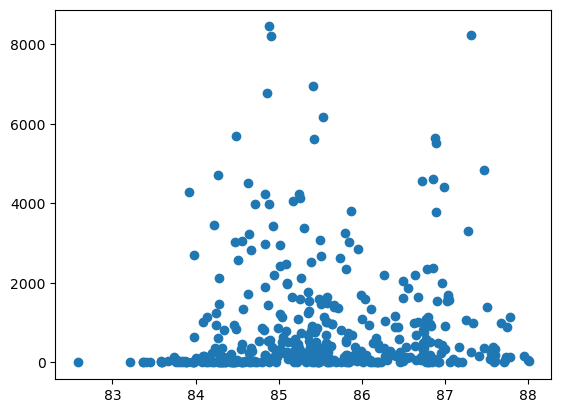

In [37]:
plt.scatter(combined_data['1mm_returnmean'], combined_data['PM10'])
#plt.xlim([-10,10])

In [38]:
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, Dense

# Create a CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1, , channels)))  # Input shape depends on your data
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # num_outputs = number of target variables

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


SyntaxError: invalid syntax (1124061073.py, line 6)

In [ ]:
np.size(X,0)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob

data_dir = glob.glob("_data/Training Images/*")

In [2]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,255))
c=1
y_pm1 = []
y_pm25 = []
y_pm425 = []
y_pm10 = []

X = []

for filename in data_dir:
    df = pd.read_csv(filename)


    if df.shape[0] == 20:
        for i in range(len(df)):
            shifted_df = pd.concat([df.iloc[:i], df.iloc[:i]], ignore_index=True)
            x_vals = df[['1cm', '1cm_intensity', '1cm_return', '1mm', '1mm_intensity', '1mm_return', '100um', '100um_intensity', '100um_return']]
            PM1 = df['PMA Value'].mean()
            PM2_5 = df['PMB Value'].mean()
            PM4_25 = df['PMC Value'].mean()
            PM10 = df['PMD Value'].mean()
            y_pm1.append(PM1)
            y_pm25.append(PM2_5)
            y_pm425.append(PM4_25)
            y_pm10.append(PM10)
            normalized_x = scaler.fit_transform(x_vals)
            #print(type(normalized_x))
            x_reshaped = normalized_x.reshape(20,3,3)
            X.append(x_reshaped)
            #print(c)
            c+=1
y_pm1 = np.array(y_pm1)
y_pm25 = np.array(y_pm25)
y_pm425 = np.array(y_pm425)
y_pm10 = np.array(y_pm10)
y_combin = np.column_stack((y_pm1, y_pm25, y_pm425, y_pm10))
X = np.array(X)

In [3]:
X.shape

(63120, 20, 3, 3)

In [61]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam

X_train, X_test, y_train, y_test = train_test_split(X, y_pm10, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(20, 3, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(64, (1, 1), activation='relu'),  # Changed kernel size
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)])  # Output layer for regression)


'''
layers.Input(shape=(20,3,3)),
layers.Rescaling(1./255),
layers.Conv2D(10, (2, 2), activation='relu'),  # Use smaller kernel size
layers.MaxPooling2D((2, 1)),      # Pooling layer
layers.Conv2D(20, (2, 2), activation='relu'),  # Use smaller kernel size
layers.GlobalAveragePooling2D(),   # Use global pooling instead of flattening
layers.Dense(20, activation='relu'),
layers.Dense(1)  # Output layer for regression
'''


def mean_absolute_error_custom(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def rmse_multivariate(y_true, y_pred):
    # Calculate RMSE for each target variable
    rmse_values = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=0))
    return rmse_values


model.compile(optimizer='nadam', loss='mean_squared_error', metrics =['mae', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_24 (Rescaling)        │ (None, 20, 3, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 20, 3, 64)      │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 10, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 10, 3, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 5, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_74 (Conv2D)              │ (None, 5, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_24     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_96 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_48 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_97 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_98 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_99 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,769 (190.50 KB)

 Trainable params: 48,769 (190.50 KB)

 Non-trainable params: 0 (0.00 B)

In [62]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('pm10.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=100,
                               restore_best_weights=True,  # Restore best model after stopping
                               verbose=1)
history = model.fit(X_train, y_train, epochs=600, batch_size=64, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/600
777/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1903384.3750 - mae: 884.1711 - root_mean_squared_error: 1378.5809
Epoch 1: val_loss improved from inf to 1792700.37500, saving model to pm10.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1901431.5000 - mae: 884.2341 - root_mean_squared_error: 1377.8790 - val_loss: 1792700.3750 - val_mae: 878.3188 - val_root_mean_squared_error: 1338.9176
Epoch 2/600
776/789 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1719421.2500 - mae: 889.5370 - root_mean_squared_error: 1311.1505
Epoch 2: val_loss improved from 1792700.37500 to 1781087.50000, saving model to pm10.keras
789/789 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1719767.7500 - mae: 889.5645 - root_mean_squared_error: 1311.2844 - val_loss: 1781087.5000 - val_mae: 906.3229 - val_root_mean_squared_error: 1334.5739
Epoch 3/600
781/789 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1723408.2500 - mae: 890.4958 - root_mean_squared_error: 1312.7290
Epoch 3: val_loss improved from 1781087.50000

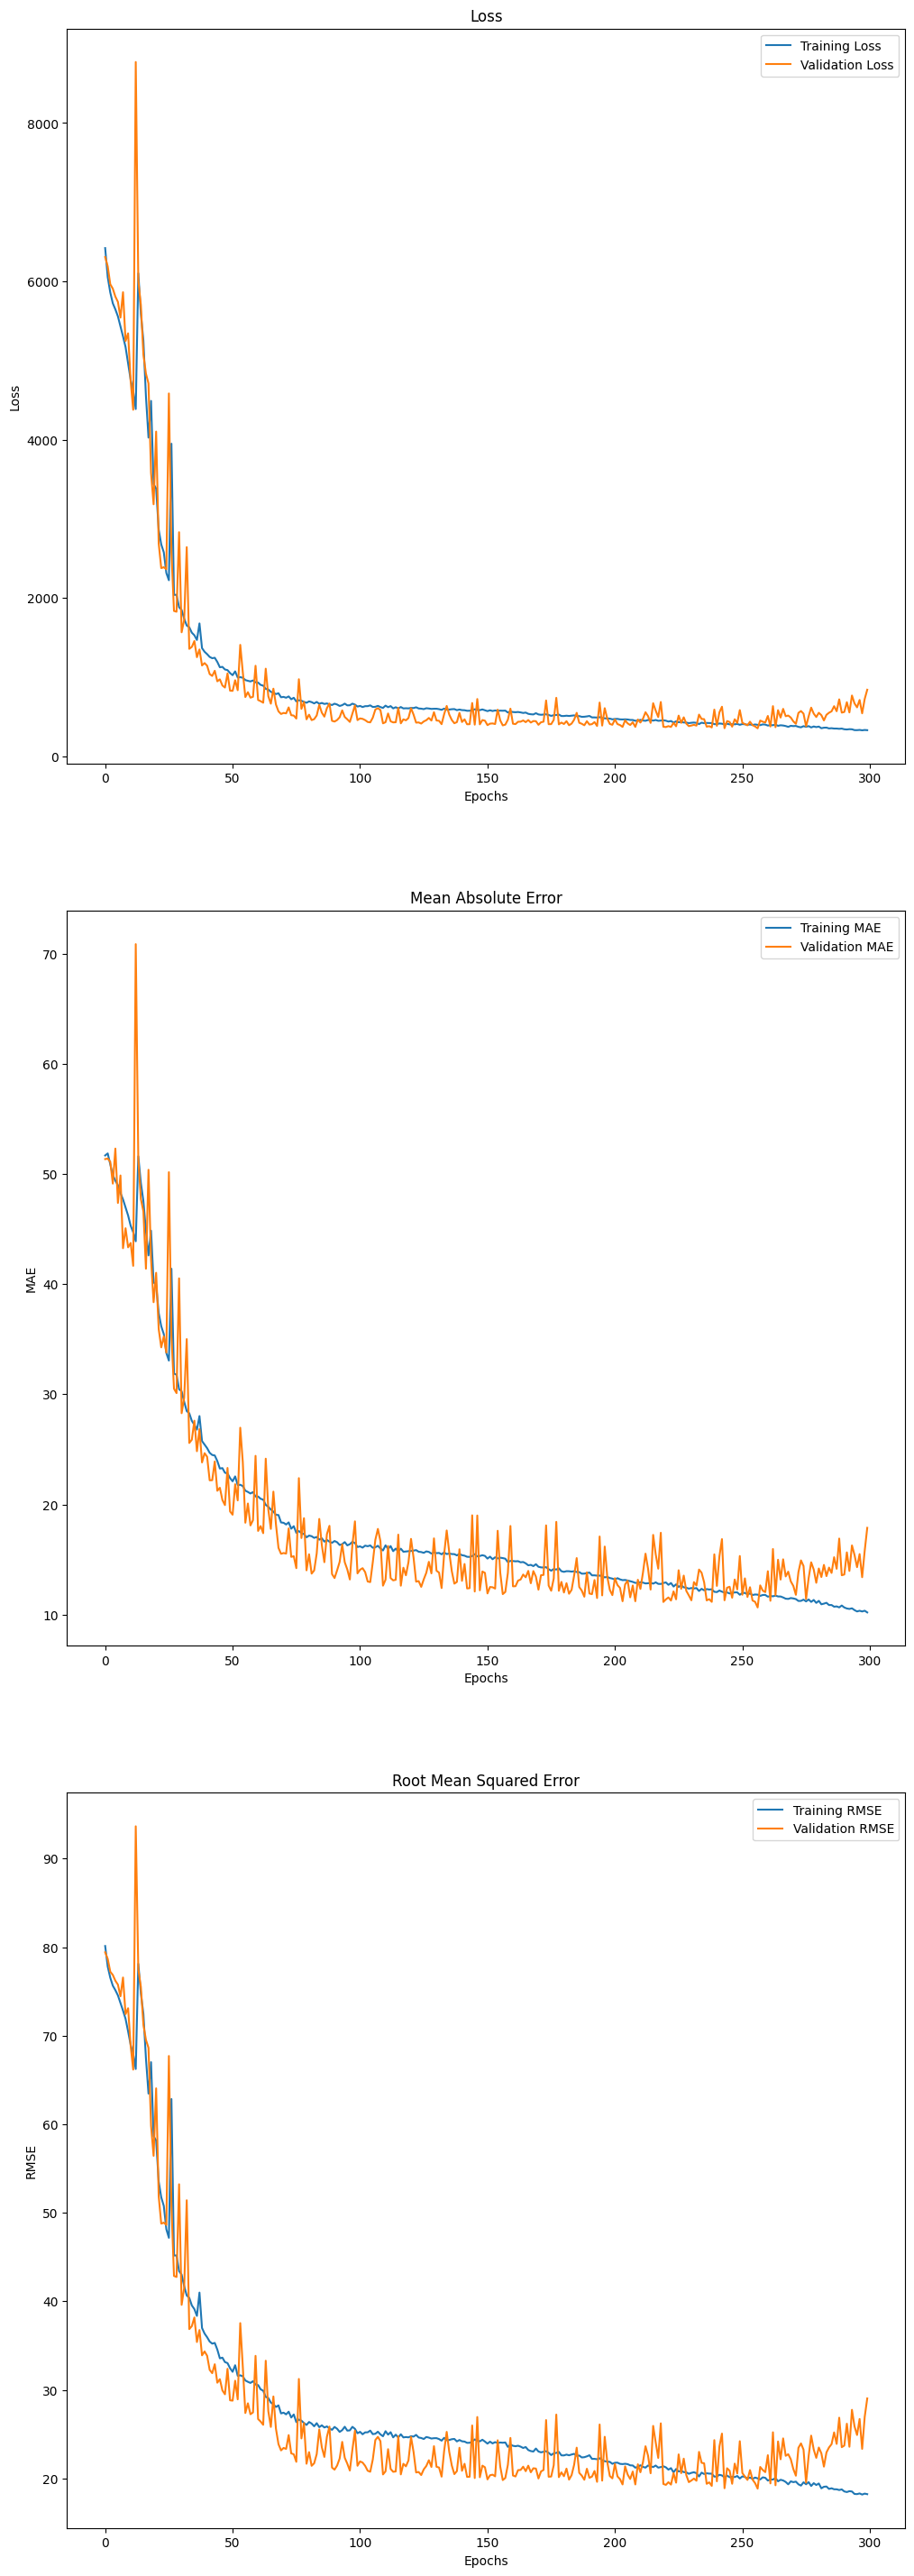

In [35]:
# Accessing the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 36))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# PM 4.25

In [57]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam

X_train, X_test, y_train, y_test = train_test_split(X, y_pm425, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(20, 3, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(64, (1, 1), activation='relu'),  # Changed kernel size
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)])  # Output layer for regression)


'''
layers.Input(shape=(20,3,3)),
layers.Rescaling(1./255),
layers.Conv2D(10, (2, 2), activation='relu'),  # Use smaller kernel size
layers.MaxPooling2D((2, 1)),      # Pooling layer
layers.Conv2D(20, (2, 2), activation='relu'),  # Use smaller kernel size
layers.GlobalAveragePooling2D(),   # Use global pooling instead of flattening
layers.Dense(20, activation='relu'),
layers.Dense(1)  # Output layer for regression
'''


def mean_absolute_error_custom(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def rmse_multivariate(y_true, y_pred):
    # Calculate RMSE for each target variable
    rmse_values = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=0))
    return rmse_values


model.compile(optimizer='nadam', loss='mean_squared_error', metrics =['mae', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_22 (Rescaling)        │ (None, 20, 3, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 20, 3, 64)      │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 10, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 10, 3, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 5, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 5, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_22     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_88 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_89 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_90 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,769 (190.50 KB)

 Trainable params: 48,769 (190.50 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('pm425.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=100,
                               restore_best_weights=True,  # Restore best model after stopping
                               verbose=1)
history = model.fit(X_train, y_train, epochs=600, batch_size=128, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/600
389/395 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 87869.5078 - mae: 187.0130 - root_mean_squared_error: 296.1905
Epoch 1: val_loss improved from inf to 82991.64844, saving model to pm425.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 87773.9922 - mae: 187.0745 - root_mean_squared_error: 296.0310 - val_loss: 82991.6484 - val_mae: 186.9391 - val_root_mean_squared_error: 288.0827
Epoch 2/600
390/395 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 79798.1328 - mae: 191.4741 - root_mean_squared_error: 282.4310
Epoch 2: val_loss improved from 82991.64844 to 82729.85938, saving model to pm425.keras
395/395 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 79795.9297 - mae: 191.4724 - root_mean_squared_error: 282.4279 - val_loss: 82729.8594 - val_mae: 185.3594 - val_root_mean_squared_error: 287.6280
Epoch 3/600
389/395 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 78371.4531 - mae: 189.4523 - root_mean_squared_error: 279.9080
Epoch 3: val_loss improved from 82729.85938 to 82199.24219, saving mod

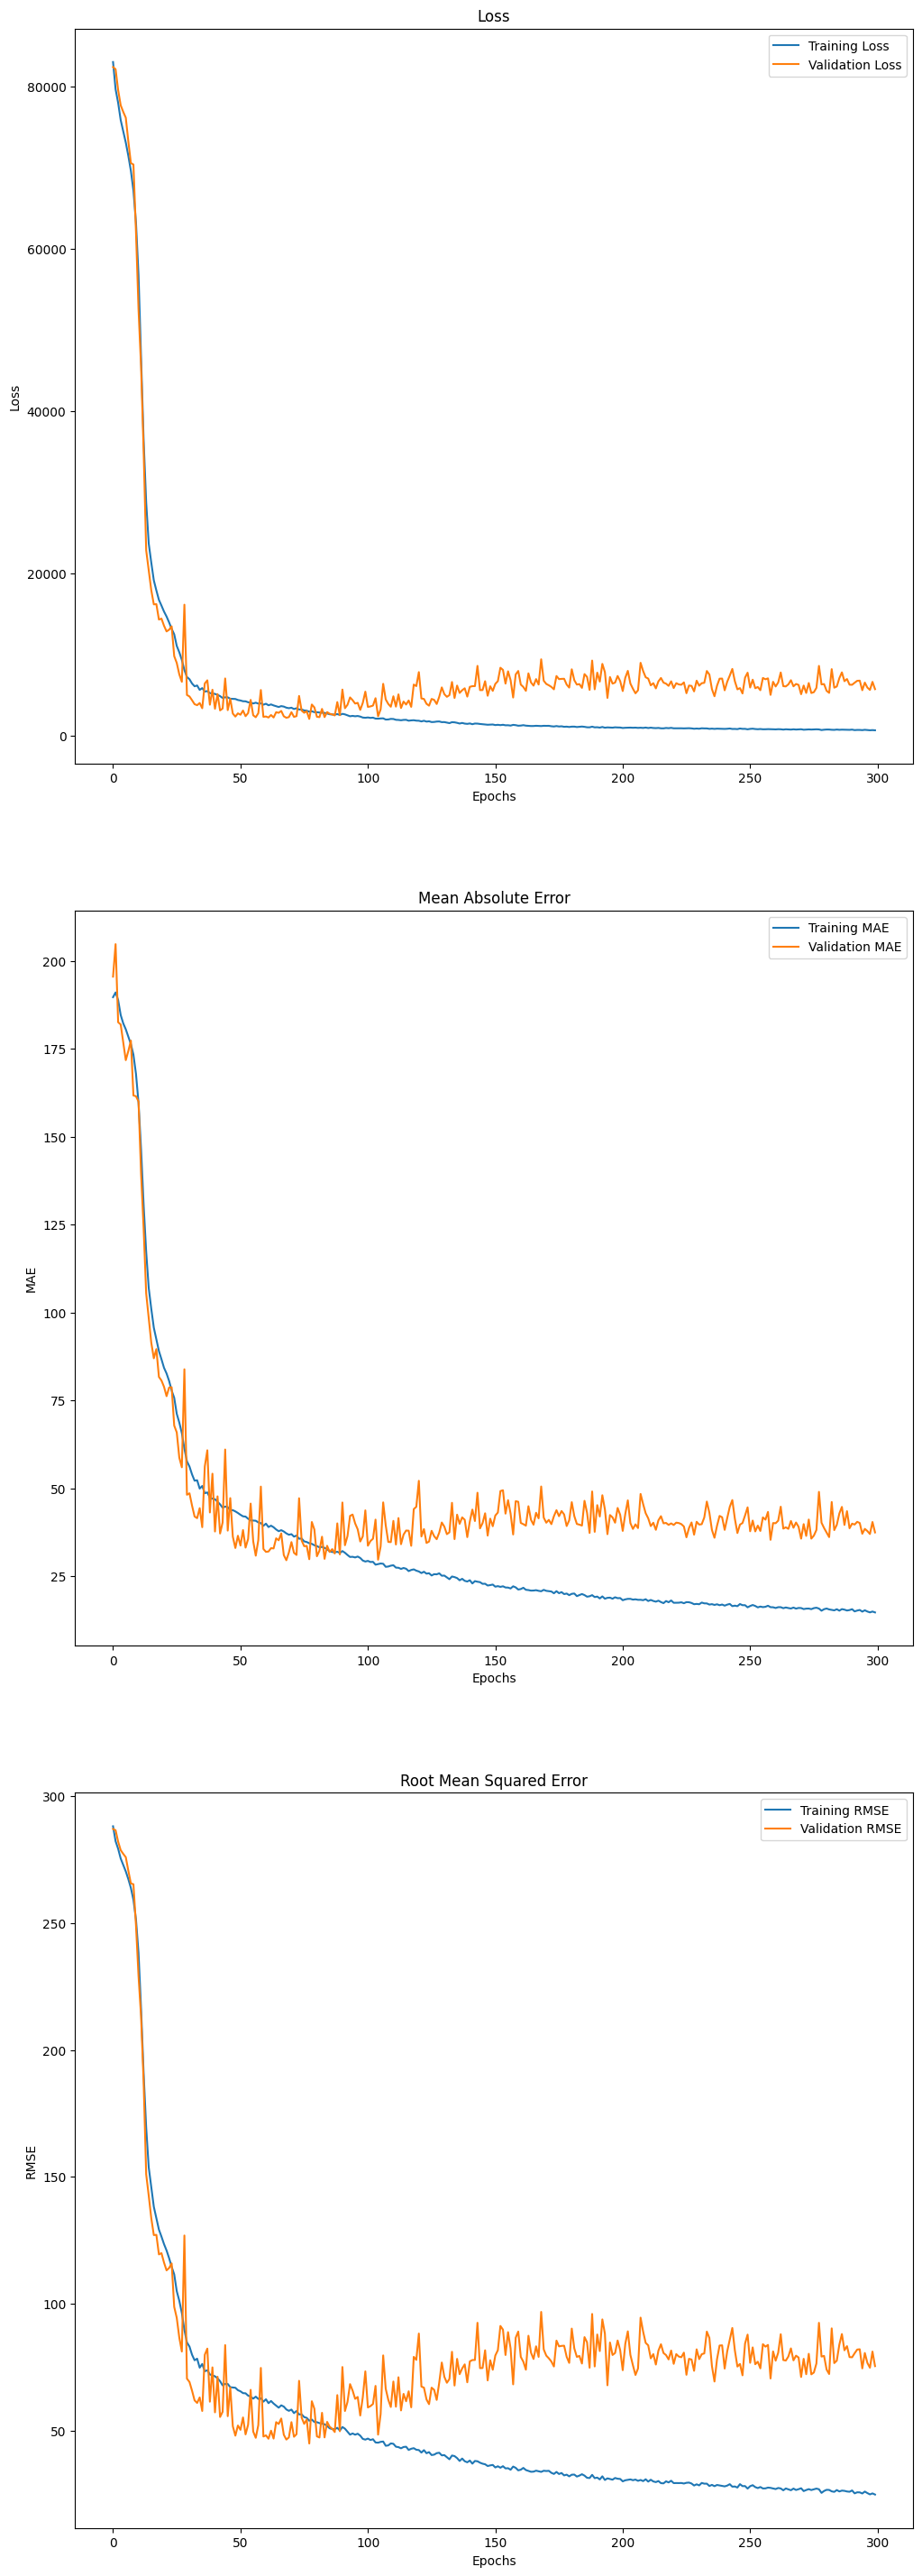

In [9]:
# Accessing the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 36))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# PM 2.5

In [55]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam

X_train, X_test, y_train, y_test = train_test_split(X, y_pm25, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(20, 3, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(64, (1, 1), activation='relu'),  # Changed kernel size
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)])  # Output layer for regression)


'''
layers.Input(shape=(20,3,3)),
layers.Rescaling(1./255),
layers.Conv2D(10, (2, 2), activation='relu'),  # Use smaller kernel size
layers.MaxPooling2D((2, 1)),      # Pooling layer
layers.Conv2D(20, (2, 2), activation='relu'),  # Use smaller kernel size
layers.GlobalAveragePooling2D(),   # Use global pooling instead of flattening
layers.Dense(20, activation='relu'),
layers.Dense(1)  # Output layer for regression
'''


def mean_absolute_error_custom(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def rmse_multivariate(y_true, y_pred):
    # Calculate RMSE for each target variable
    rmse_values = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=0))
    return rmse_values


model.compile(optimizer='nadam', loss='mean_squared_error', metrics =['mae', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_21 (Rescaling)        │ (None, 20, 3, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 20, 3, 64)      │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 10, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 10, 3, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 5, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 5, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_84 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,769 (190.50 KB)

 Trainable params: 48,769 (190.50 KB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('pm25.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=100,
                               restore_best_weights=True,  # Restore best model after stopping
                               verbose=1)
history = model.fit(X_train, y_train, epochs=600, batch_size=256, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])

Epoch 1/600
197/198 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 6872.5972 - mae: 50.9476 - root_mean_squared_error: 82.8097
Epoch 1: val_loss improved from inf to 6272.35254, saving model to pm25.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 6867.4170 - mae: 50.9549 - root_mean_squared_error: 82.7788 - val_loss: 6272.3525 - val_mae: 53.9261 - val_root_mean_squared_error: 79.1982
Epoch 2/600
194/198 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5997.1719 - mae: 51.7911 - root_mean_squared_error: 77.4348
Epoch 2: val_loss improved from 6272.35254 to 6181.43652, saving model to pm25.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5998.2573 - mae: 51.7943 - root_mean_squared_error: 77.4419 - val_loss: 6181.4365 - val_mae: 50.6597 - val_root_mean_squared_error: 78.6221
Epoch 3/600
195/198 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5864.8901 - mae: 51.0417 - root_mean_squared_error: 76.5713
Epoch 3: val_loss improved from 6181.43652 to 5905.14453, saving model to pm25.keras
198/198 ━━━

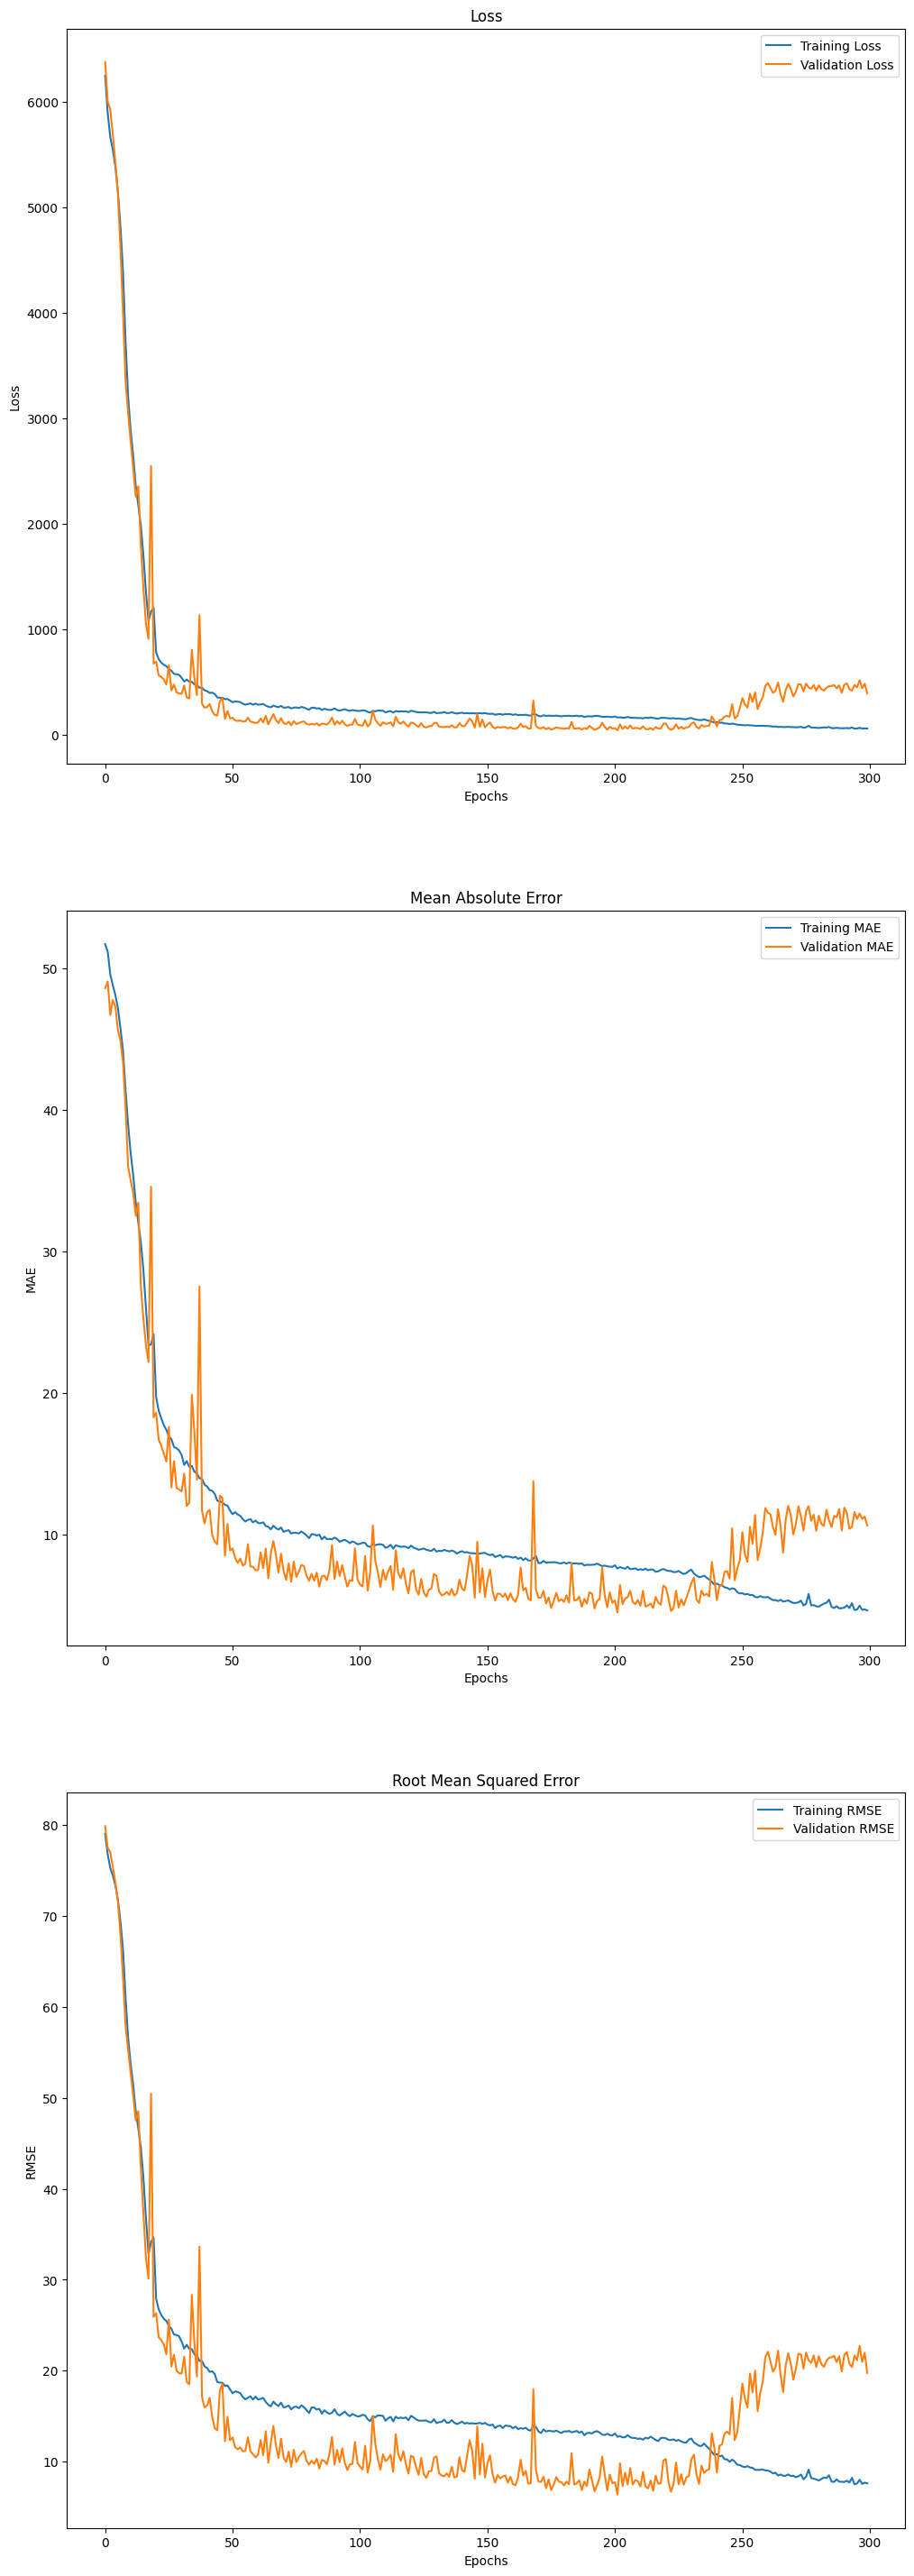

In [12]:
# Accessing the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 36))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()

# PM 1

In [53]:
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Nadam

X_train, X_test, y_train, y_test = train_test_split(X, y_pm25, test_size=0.2, random_state=42)

model = models.Sequential([
    layers.Input(shape=(20, 3, 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(64, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(128, (2, 2), activation='relu', padding='same'),  # Added padding
    layers.MaxPooling2D((2, 1)),  # Adjusted pooling parameters
    layers.Conv2D(64, (1, 1), activation='relu'),  # Changed kernel size
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)])  # Output layer for regression)


'''
layers.Input(shape=(20,3,3)),
layers.Rescaling(1./255),
layers.Conv2D(10, (2, 2), activation='relu'),  # Use smaller kernel size
layers.MaxPooling2D((2, 1)),      # Pooling layer
layers.Conv2D(20, (2, 2), activation='relu'),  # Use smaller kernel size
layers.GlobalAveragePooling2D(),   # Use global pooling instead of flattening
layers.Dense(20, activation='relu'),
layers.Dense(1)  # Output layer for regression
'''


def mean_absolute_error_custom(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def root_mean_squared_error(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

def rmse_multivariate(y_true, y_pred):
    # Calculate RMSE for each target variable
    rmse_values = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred), axis=0))
    return rmse_values


model.compile(optimizer='nadam', loss='mean_squared_error', metrics =['mae', tf.keras.metrics.RootMeanSquaredError()])
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_20 (Rescaling)        │ (None, 20, 3, 3)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 20, 3, 64)      │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 10, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 10, 3, 128)     │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 5, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 5, 3, 64)       │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_20     │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_80 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_81 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_82 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_83 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,769 (190.50 KB)

 Trainable params: 48,769 (190.50 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
checkpoint = ModelCheckpoint('pm1.keras', monitor='val_loss', save_best_only=True, mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=100,
                               restore_best_weights=True,  # Restore best model after stopping
                               verbose=1)
history = model.fit(X_train, y_train, epochs=600, batch_size=256, validation_data=(X_test, y_test), callbacks=[checkpoint, early_stopping])


Epoch 1/600
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6722.4834 - mae: 50.4357 - root_mean_squared_error: 81.9492
Epoch 1: val_loss improved from inf to 6272.87402, saving model to pm1.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 6720.6597 - mae: 50.4416 - root_mean_squared_error: 81.9381 - val_loss: 6272.8740 - val_mae: 52.6694 - val_root_mean_squared_error: 79.2015
Epoch 2/600
196/198 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6111.7778 - mae: 52.3171 - root_mean_squared_error: 78.1726
Epoch 2: val_loss improved from 6272.87402 to 6133.49512, saving model to pm1.keras
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6110.2539 - mae: 52.3082 - root_mean_squared_error: 78.1629 - val_loss: 6133.4951 - val_mae: 50.4021 - val_root_mean_squared_error: 78.3166
Epoch 3/600
198/198 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5793.7983 - mae: 50.7620 - root_mean_squared_error: 76.1101
Epoch 3: val_loss improved from 6133.49512 to 5947.27832, saving model to pm1.keras
198/198 ━━━━━

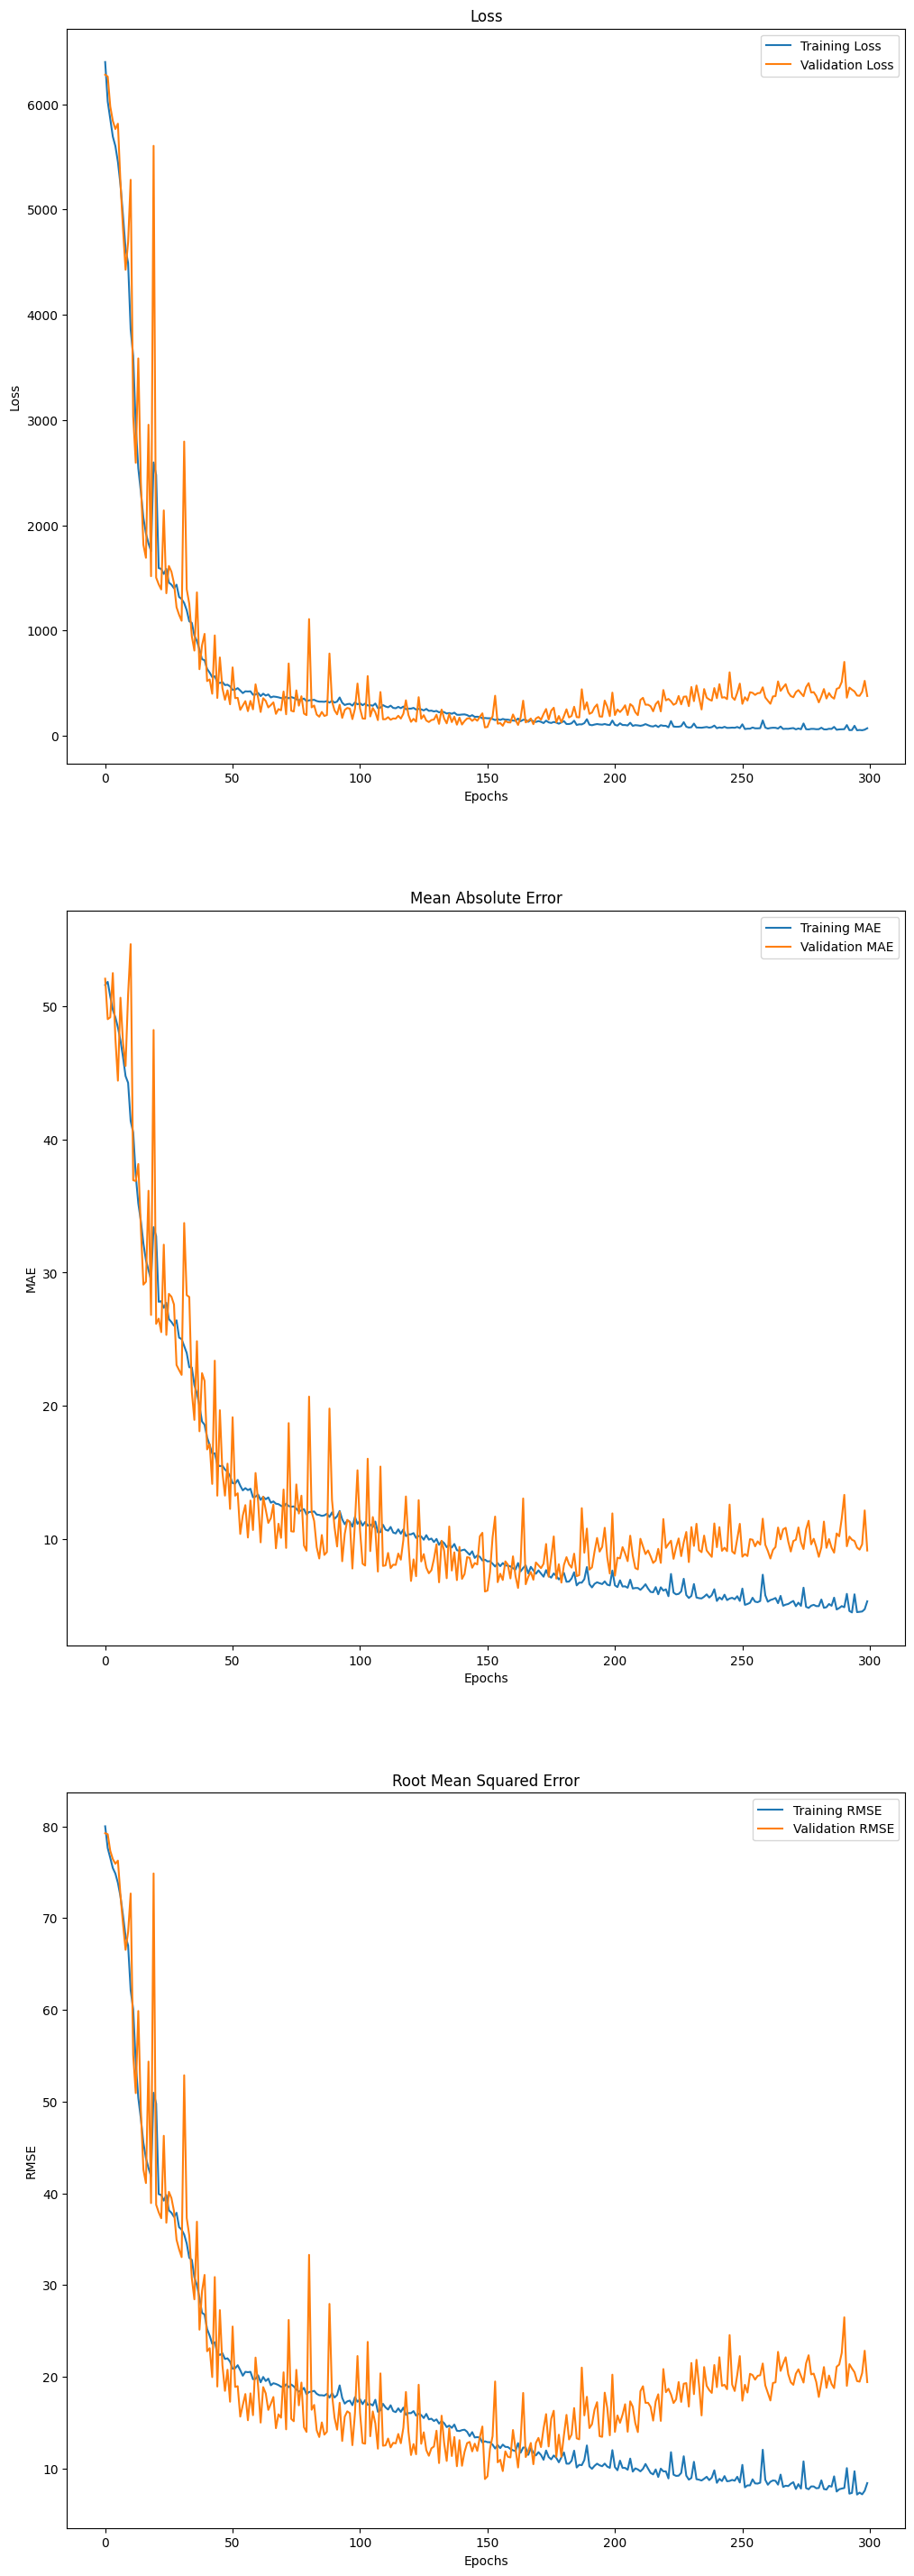

In [15]:
# Accessing the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mae']
val_mae = history.history['val_mae']
train_rmse = history.history['root_mean_squared_error']
val_rmse = history.history['val_root_mean_squared_error']



import matplotlib.pyplot as plt

plt.figure(figsize=(12, 36))

# Plot Loss
plt.subplot(3, 1, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot MAE
plt.subplot(3, 1, 2)
plt.plot(train_mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.title('Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(train_rmse, label='Training RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.title('Root Mean Squared Error')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()